# 로지스틱 회귀 모델을 통한 7번방의 선물 리뷰 분석

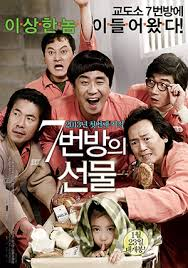

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

pres = ["https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=94775&type=after&onlyActualPointYn=N&onlySpoilerPointYn=N&order=highest&page=",
       "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=94775&type=after&onlyActualPointYn=N&onlySpoilerPointYn=N&order=lowest&page="]
review = []
rate = []
target = []

for pre in pres:
    for i in range(1,200):
        url = pre + str(i)
        res = requests.get(url)

        soup = BeautifulSoup(res.content,'html.parser')

        id_list = []
        id_pre = "_filtered_ment_"

        for i in range(10):
            id_list.append(id_pre+str(i))

        for id in id_list:
            review.append(soup.find("span", {"id":id}).get_text().strip())

        rate_list = []
        rate_list = (soup.select("div.star_score > em"))

        for i in range(10):
            r = int(re.sub("<.+?>", "", str(rate_list[i])))
            rate.append(r)
            if r >= 8:
                target.append(1) # 평점이 8 이상인 경우 고득점인 1 지정
            elif r<=4:
                target.append(0)
            else:
                targe.append(-1)

df = pd.DataFrame({"review" : review, "rate" : rate, "target":target})

In [2]:
df.to_csv("../data/review.csv")

In [2]:
df

,review,rate,target
0,눈물정말 많이 나왔습니다...,10,1
1,연년생 아이 키우면서 우울해서 뛰쳐나와 영화관에서 이 영화보고 눈물콧물 다 흘리고....,10,1
2,보고 또봐도 눈물이 나오는 영화. 배우들의 연기력과 합도 잘맞고 스토리도 참신하다 ...,10,1
3,,10,1
4,아니 제발 평점 다시는 분들 중에 영화 스토리 욕하시는 분들 이 영화 장르 좀 알고...,10,1
...,...,...,...
3975,이 영화 돈주고 본거 진짜 아깝네요 전 영화관에서 보면 아무리 망작이라도아깝다는 생...,1,0
3976,시작부터 예고된 감동이 과연 감동적일까? 억지스럽다라는 표현이 정말 공감가는 영화다...,1,0
3977,억지설정. 법률자문이 있었다는 사실에 경악.,1,0
3978,내가 한국 코미디영화를 안보는 이유 겉만 코미디지 억지감동 유발시켜 관객동정을 얻으...,1,0


In [3]:
import numpy as np

In [4]:
np.sum(df["target"]==-1) # target 값이 -1인 경우는 없는 것으로 확인.

0

In [5]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(review, target, test_size = 0.2, random_state=0)

In [6]:
len(train_x), len(train_y)

(3184, 3184)

In [7]:
len(test_x), len(test_y)

(796, 796)

In [8]:
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfVectorizer

twitter = Twitter()

tfv = TfidfVectorizer(tokenizer=twitter.morphs, ngram_range=(1,2), min_df=3, max_df = 0.9)
tfv.fit(train_x)

tfv_train_x = tfv.transform(train_x)
tfv_train_x

C:\Users\Kim\AppData\Roaming\Python\Python37\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


<3184x3950 sparse matrix of type '<class 'numpy.float64'>'
	with 51572 stored elements in Compressed Sparse Row format>

## 모델 생성

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(random_state=0)
params = {"C":[1,3,5,7,9]}
grid_cv = GridSearchCV(clf, param_grid=params, cv = 4, scoring='accuracy', verbose=1)
grid_cv.fit(tfv_train_x, train_y)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None, param_grid={'C': [1, 3, 5, 7, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

## 예측 정확도

In [10]:
tfv_test_x = tfv.transform(test_x)
grid_cv.best_estimator_.score(tfv_test_x, test_y)

0.885678391959799

## 모델 성능 평가

In [11]:
r=["시간 아깝네요.","스토리 전개가 고구마 먹는 듯 답답","조연이 살렸네요","도무지 주제도 모르겠고 멀 전달하려는지 모르겠음","아무 생각없이 보면 재미있는 것 같기는 한데 추천하고 싶진 않네요.",
  "몰입도가 높은 영화입니다. 시간 가는 줄 몰랐네요.","곱씹을수록 잘 만들어진 영화인 것 같아요. 다시 볼 겁니다.","어이가 없네","평점 알바 왜이렇게 많냐",
  "일상의 고단함을 잊게 해주었던 인생영화"]
my_review = tfv.transform(r)
grid_cv.best_estimator_.predict(my_review)

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 1])

## 예측 결과 두 개의 리뷰를 제외하고 좋은 예측 성능을 보였다.